In [30]:
#import the appropriate dependencies
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#import the data into a dataframe: df
# download the data from 'https://www.kaggle.com/austinreese/craigslist-carstrucks-data?select=vehicles.csv'

csv_file = './data/vehicles.csv'

df = pd.read_csv(csv_file)

In [4]:
#check what the data head looks like
df.head(3)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7184791621,https://duluth.craigslist.org/ctd/d/duluth-200...,duluth / superior,https://duluth.craigslist.org,6995,2000.0,gmc,new sierra 1500,excellent,8 cylinders,...,4wd,NaN,NaN,red,https://images.craigslist.org/00n0n_f06ykBMcdh...,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,NaN,mn,46.8433,-92.2550
1,7184773187,https://duluth.craigslist.org/cto/d/saginaw-20...,duluth / superior,https://duluth.craigslist.org,8750,2013.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,NaN,grey,https://images.craigslist.org/00d0d_kgZ6xoeRw2...,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,NaN,mn,46.9074,-92.4638
2,7193375964,https://newhaven.craigslist.org/cto/d/stratfor...,new haven,https://newhaven.craigslist.org,10900,2013.0,toyota,prius,good,4 cylinders,...,fwd,NaN,NaN,blue,https://images.craigslist.org/00d0d_3sHGxPbY2O...,2013 Prius V Model Two. One owner—must sell my...,NaN,ct,41.1770,-73.1336


In [5]:
#view descriptive statistics from numerical columns
df.describe()

,id,price,year,odometer,county,lat,long
count,4.238570e+05,4.238570e+05,328743.000000,2.705850e+05,0.0,324404.000000,324404.000000
mean,7.190602e+09,5.779437e+04,2009.827358,9.942578e+04,NaN,38.731429,-93.949367
std,5.159269e+06,1.002581e+07,10.135809,1.204833e+05,NaN,5.902977,17.930566
min,7.178302e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-80.386400,-161.394000
25%,7.186688e+09,4.499000e+03,2007.000000,4.432400e+04,NaN,35.054500,-106.678000
50%,7.192068e+09,9.995000e+03,2012.000000,9.174900e+04,NaN,39.366900,-88.009900
75%,7.194909e+09,1.899500e+04,2016.000000,1.372370e+05,NaN,42.517075,-80.832500
max,7.197006e+09,3.808256e+09,2021.000000,1.000000e+07,NaN,80.383400,115.524000


Not all the data will be relevant to the current business model. Taking a look at the minimum odometer reading tells us that there is at least one new car in the data, which might affect our model for used car prices. **So, consider dropping the rows with 0 miles in 'odometer'** 

The min and max values in 'price' are 0 and 3808256046 respectively. Such a high price makes me think this is a typo. We can either try to find the data manually from its source to check or **drop anything over 500,000 dollars completely**. Similarly, **we will drop any vehicles that have a price under 100 dollars for consistency.**

The 'year' column has a max value of 2021, which tells us that it is a new car because it is next year's date. To correct for this new car, we will **drop the rows with a year of 2021.** Similarly, the scope of this project only involves vehicles 30 years old or younger. Consequently, we will drop any irrelevant data by **dropping all rows that have a year less than 1990.**

In [15]:
#view a list of the column names
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [7]:
#check the types of data for each column
df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
vin              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
dtype: object

Looking at the types of data per column gives insight to how we will manipulate the data. Also, we can anticipate needing dummy variables in out preprocessing phase later. 

Cylinders is currently an object (string), but it may be more sensible to convert this to an int64.

In [12]:
#check for empty values
df.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year             95114
manufacturer    110615
model            98473
condition       247138
cylinders       226178
fuel             96643
odometer        153272
title_status     96098
transmission     95792
vin             239437
drive           192738
size            321230
type            182700
paint_color     201654
image_url        94196
description      94203
county          423857
state                0
lat              99453
long             99453
dtype: int64

<AxesSubplot:>

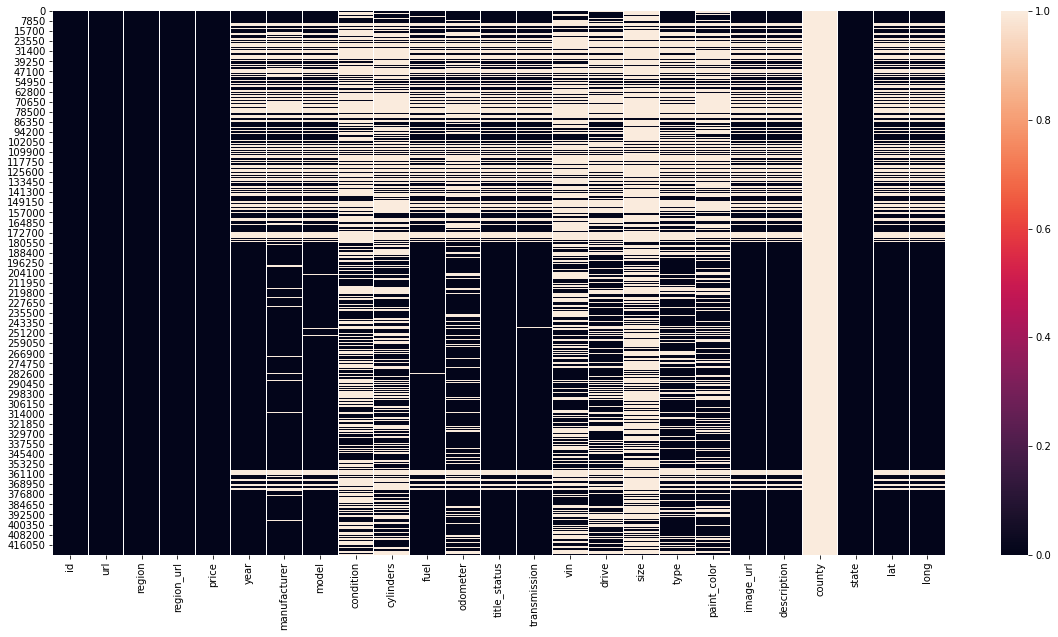

In [31]:
#set the size of the plot to make it easier to view
plt.figure(figsize=(20,10))

#use seaborn's heatmap to visualize where the null values are
sns.heatmap(df.isnull())

**There is a lot of missing data in this dataset.** Once we explore the data and understand more about how the columns correlate, we will be able to make an informed decision on what to do. **Some options include deleting entire rows and imputing with mean or other stats.**  

County does not have any values in it. **Does the county column add any value?** 

**These columns have the most missing values: condition, cylinders, vin, drive, size, type, paint_color, and county.**

In [55]:
#check for unique models
df['model'].value_counts()

f-150                                         6073
silverado 1500                                3878
escape                                        3208
camry                                         2906
1500                                          2898
                                              ... 
1500 classic warlock 4x4 crew cab 5'7" box       1
3500 drw cummins                                 1
civic del sol si                                 1
Olds 98 Regency                                  1
x5 4.8is                                         1
Name: model, Length: 27042, dtype: int64

Wow. The model column is messy. **We will need to tidy up this column.** At this time, we will only briefly mention that we will need NLP to handle this task so that we can account for misspelled words with the string similarity tool from NLP. In the meantime, we will continue without this column holding any weight in our analysis. 

In [54]:
#check for unique models
df['region'].value_counts().sort_values()

fort smith, AR            1
st louis                  5
west virginia (old)      14
kansas city              15
meridian                 22
                       ... 
salem                  2985
rochester              3087
jacksonville           3284
springfield            3294
columbus               3296
Name: region, Length: 404, dtype: int64

There is some inconsistency with 'region'. Some of the values are cities, while others are city and state or less specific regions like 'central NJ'. This doesn't appear to be a problem for our model at this time. 

In [62]:
#check for duplicates
if df.duplicated().sum() == 0:
    print('No duplicates!')
else:
    df.duplicated().sum()

No duplicates!


In [68]:
#define the conditions to drop
zero_odometer = df['odometer']<5000
max_price = df['price']>=500000
min_price = df['price']<=100
future_year = df['year']==2021
min_year = df['year']<1990

#drop those conditions
dropped_df = df.drop(df.loc[zero_odometer|max_price|min_price|future_year|min_year].index)

dropped_df.describe()

,id,price,year,odometer,county,lat,long
count,3.673810e+05,367381.00000,280346.000000,2.358140e+05,0.0,279343.000000,279343.000000
mean,7.190709e+09,15043.18888,2011.059141,1.042051e+05,NaN,38.788533,-93.790007
std,5.157905e+06,13701.66971,5.891999,1.101406e+05,NaN,5.944142,17.833631
min,7.178302e+09,101.00000,1990.000000,5.000000e+03,NaN,-80.386400,-161.394000
25%,7.186855e+09,5950.00000,2007.000000,5.048800e+04,NaN,35.083750,-106.522000
50%,7.192309e+09,11495.00000,2012.000000,9.624200e+04,NaN,39.494500,-87.843300
75%,7.195000e+09,19990.00000,2016.000000,1.415875e+05,NaN,42.586550,-80.958900
max,7.197006e+09,479500.00000,2020.000000,1.000000e+07,NaN,80.383400,115.524000


In [92]:
#drop county column
#this command is commented out because if it gets run twice then there is an error.
#dropped_df.drop(columns=['county'], inplace=True)

#check if county column dropped
set(dropped_df.columns).symmetric_difference(set(df.columns))

{'county'}